# Densest Square

This notebook is inspired by Alasdair Rae's work displaying "The Most Densely Populated Square Kilometre in 39 European Countries"
http://www.statsmapsnpix.com/2018/01/the-most-densely-populated-square.html

Following his work, I create a notebook so that anyone can reproduce it easily across the world.
Note. The result might be different since I am using GPWv4 and GHSL here instead of Eurostat's population grid.

The workflow is:

1. with a downloaded population grid raster
2. automatically retrieve city boudnary with place name using osmnx
3. clip the raster with the city boundary
4. identify a square of 1km with maximum population
5. retrieve satellite image of the square from Google
6. Provide  the result with satelite image, population grid, url to Google Map of the location.

https://www.google.com/maps/@40.78224545274604,-73.9514875912007,600m/data=!3m1!1e3


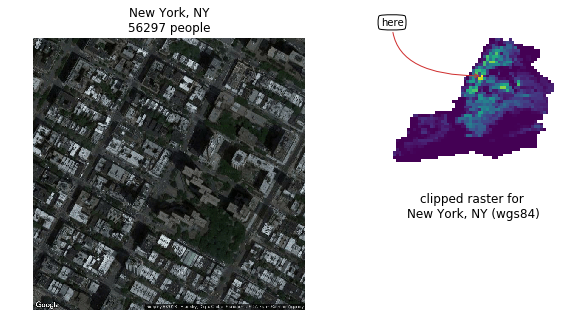

In [71]:
# run this later
densest_square("New York, NY")

In [72]:
# import
import os
import warnings

from matplotlib import pyplot as plt
from numpy import unravel_index
import numpy as np

from io import BytesIO
from PIL import Image
import requests

from rasterstats import zonal_stats
import rasterstats
import rasterio
from rasterio.plot import show
import osmnx as ox

warnings.filterwarnings('ignore')

## Data sources 

### Population Raster

I tested this notebook with two population datasets. 

####  Gridded Population of the World, Version 4 (GPWv4) from Center for International Earth Science Information Network - CIESIN.
This raster dataset (~420MB) contains population counts to 30 arc-second grid cells (~1 km at the equator) resolution covering the world. I used 2015's estimation. Dataset is available from here:
http://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-rev10

#### GHS POPULATION GRID

This raster dataset has two options for resolutions: 250m, and 1km. I used 1km dataset for 2015. Note that this dataset's crs is World Mollweide (EPSG:54009). Dataset is available from here:
http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/

In [4]:
#raster_path = "../data/gpw/gpw_v4_population_count_rev10_2015_30_sec.tif"
raster_path = "../data/ghsl/GHS_POP_GPW42015_GLOBE_R2015A_54009_1k_v1_0_wgs84.tif"
print(rasterio.open(raster_path).crs)

CRS({'init': 'epsg:4326'})


#### reprojection
If raster's crs is not epsg:4326, change it to epsg:4326.
https://mapbox.github.io/rasterio/topics/reproject.html

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, RESAMPLING

dst_crs = 'EPSG:4326'
src = rasterio.open(raster_path)
transform, width, height = calculate_default_transform(
    src.crs, dst_crs, src.width, src.height, *src.bounds)
kwargs = src.meta.copy()
kwargs.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})

raster_converted = ".." + raster_path.split(".")[-2] + "_wgs84." + raster_path.split(".")[-1]
if os.path.exists(raster_converted):
    os.remove(raster_converted)
print(raster_converted)

with rasterio.open(raster_converted, 'w', **kwargs) as dst:
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=rasterio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=RESAMPLING.nearest)
        
raster_path = raster_converted

###  City boundary 
I used osmnx to get a city boundary. It provides a convenient method for extracting a city boudnary from osm dataset with place name. 
See: https://github.com/gboeing/osmnx

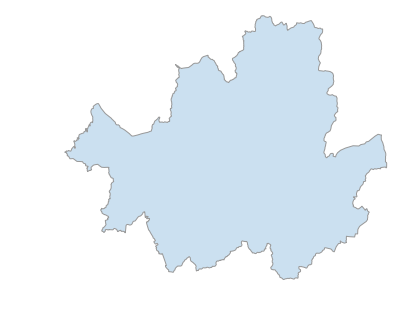

(<matplotlib.figure.Figure at 0x15184e0e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x151855ccf8>)

In [5]:
city = ox.gdf_from_place('Seoul, Korea')
ox.plot_shape(ox.project_gdf(city))

### Satellite view 
Satellite view comes from Google map. Size is 800*800 with zoom level 17, which gives roughly 1km by 1km square.

In [6]:
def get_satellite_view(lng, lat, zoom=17):
    GSV_API_KEY = os.environ["GSV_API_KEY"] # use your key
    save_dir = "../satellite-view"
    base = "https://maps.googleapis.com/maps/api/staticmap?size=800x800"
    latlng = "center={},{}".format(lat, lng)
    view = "zoom={}&maptype=satellite".format(zoom)
    key = "key={}".format(GSV_API_KEY)
    url = "{}&{}&{}".format(base, latlng, view, key)
    res = requests.get(url)
    return res.content

## find lat/lng where population is max in a boundary
I utilized awesome [rasterstats](https://github.com/perrygeo/python-rasterstats) for this process. This provides a convinient method summarizing raster by boundary. See the code below.

In [7]:
def max_lng_lat(boundary, raster_path):
    '''find max population lng lat within city boundary'''

    r = zonal_stats(
        boundary,
        raster_path,
        all_touched=True, 
        stats="max",
        # the lambda function finds row, col of max population
        add_stats={'maxcell':lambda x: unravel_index(x.argmax(), x.shape)},
        raster_out=True)[0]
    
    def xy(transform, row, col):
        ''' converts row col to lng lat'''
        coff, roff = (0.5, 0.5)
        x, y = transform * transform.translation(coff, roff) * (col, row)
        return x, y

    lng, lat = xy(r['mini_raster_affine'], *r['maxcell'])
    return lng, lat, r['max'], r['mini_raster_array'], r['maxcell']

## function for plot

In [63]:
def densest_square(place_name):
    boundary = ox.gdf_from_place(place_name)
    lng, lat, density, rs, (row, col) = max_lng_lat(boundary, raster_path)
    print("https://www.google.com/maps/@{},{},600m/data=!3m1!1e3".format(lat, lng))
    image = get_satellite_view(lng, lat)
    im = Image.open(BytesIO(image))
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(111)
    ax1.axis('off')
    ax1.set_title("{}\n{:.0f} people".format(place_name, density))
    ax1.imshow(im)
    ax2 = fig.add_subplot(222)
    ax2.axis('off')
    ax2.annotate("here",
                 xy=(col, row), xycoords='data',
                 xytext=(-5, -5), textcoords='data',
                 bbox=dict(boxstyle="round4", fc="w"),
                 arrowprops=dict(arrowstyle="->",
                                 color='#D03030',
                                 connectionstyle="angle3"),
                )
    ax2.set_title("clipped raster for \n{} (wgs84)".format(place_name),y=-.5)
    show(rs, ax=ax2)

# Cities

https://www.google.com/maps/@40.78224545274604,-73.9514875912007,600m/data=!3m1!1e3


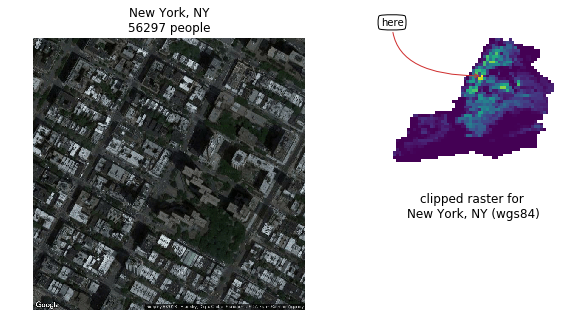

In [64]:
densest_square("New York, NY")

https://www.google.com/maps/@37.583558875959184,127.09037733006221,600m/data=!3m1!1e3


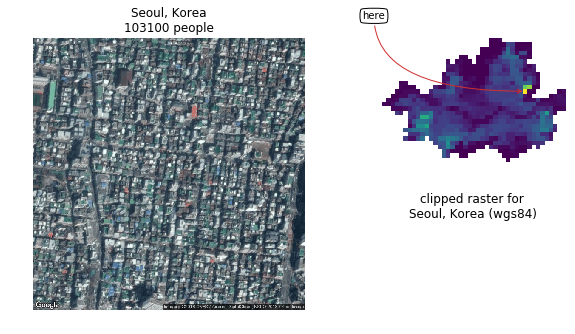

In [66]:
densest_square("Seoul, Korea")

https://www.google.com/maps/@41.901785754621436,-87.62549302113595,600m/data=!3m1!1e3


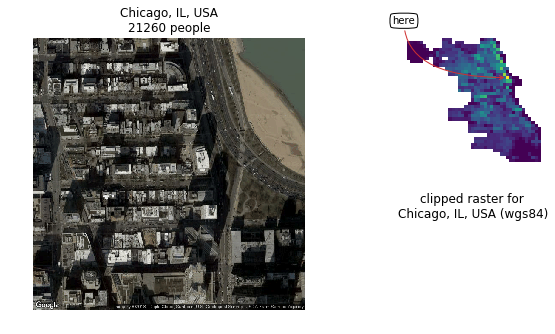

In [67]:
densest_square("Chicago, IL, USA")

https://www.google.com/maps/@51.52783317163939,-0.2038179551902578,600m/data=!3m1!1e3


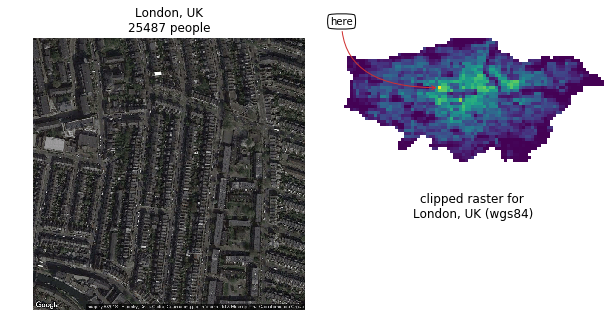

In [68]:
densest_square("London, UK")

https://www.google.com/maps/@-33.877098428569695,151.20980357453132,600m/data=!3m1!1e3


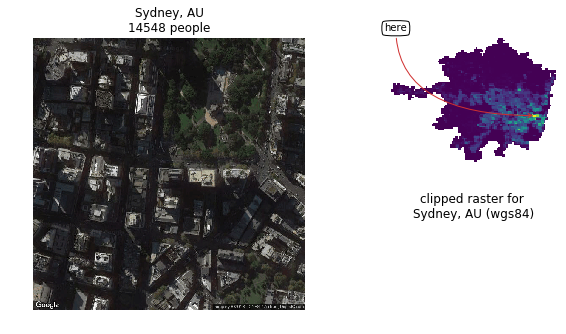

In [69]:
densest_square("Sydney, AU")